# 베이스라인 모델

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
pwd

'/home/tw/tmp/ds4th_study/tyoung/ch06 - Bike Sharing Demand'

In [5]:
data_path = '../../source/dataset/bikesharing/'

train = pd.read_csv(os.path.join(data_path, 'train.csv'))
test = pd.read_csv(os.path.join(data_path, 'test.csv'))
submission = pd.read_csv(os.path.join(data_path, 'sampleSubmission.csv'))

## 피처 엔지니어링

### 이상치 제거

In [6]:
train = train[train['weather'] != 4]

### 데이터 합치기

In [7]:
train.shape, test.shape

((10885, 12), (6493, 9))

In [8]:
all_data = pd.concat([train, test], ignore_index=True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


### 파생 피처(변수) 추가

In [9]:
all_data['datetime'] = pd.to_datetime(all_data['datetime'])
# all_data['date'] = all_data['datetime'].dt.date
all_data['year'] = all_data['datetime'].dt.year
# all_data['month'] = all_data['datetime'].dt.month
all_data['hour'] = all_data['datetime'].dt.hour
all_data['weekday'] = all_data['datetime'].dt.weekday

### 필요 없는 피처 제거

In [10]:
drop_features = ['casual', 'registered', 'datetime',  'windspeed']
all_data = all_data.drop(drop_features, axis=1)
all_data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,count,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,16.0,2011,0,5
1,1,0,0,1,9.02,13.635,80,40.0,2011,1,5
2,1,0,0,1,9.02,13.635,80,32.0,2011,2,5
3,1,0,0,1,9.84,14.395,75,13.0,2011,3,5
4,1,0,0,1,9.84,14.395,75,1.0,2011,4,5


### 데이터 나누기

In [11]:
X_train = all_data[~all_data['count'].isna()]
X_test = all_data[all_data['count'].isna()]

In [12]:
y = train['count']
X_train = X_train.drop('count', axis=1)
X_test = X_test.drop('count', axis=1)

In [13]:
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,0,5
1,1,0,0,1,9.02,13.635,80,2011,1,5
2,1,0,0,1,9.02,13.635,80,2011,2,5
3,1,0,0,1,9.84,14.395,75,2011,3,5
4,1,0,0,1,9.84,14.395,75,2011,4,5


## 평가지표 계산 함수 작성

In [14]:
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    output = np.sqrt(np.mean((log_true  - log_pred)**2))
    return output

In [15]:
np.log(1e-100+1), np.log1p(1e-100), np.log1p(0)

(0.0, 1e-100, 0.0)

## 모델 훈련

In [16]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
log_y = np.log(y)

linear_reg.fit(X_train, log_y)

LinearRegression()

## 모델 성능 검증

In [17]:
preds = linear_reg.predict(X_train)
print(f'선형 회귀의 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

선형 회귀의 RMSLE 값 : 1.0205


## 예측 및 결과 제출

In [18]:
preds = linear_reg.predict(X_test)
submission['count'] = np.exp(preds)
submission.to_csv('submission.csv', index=False)

# 성능 개선 1 : 릿지 회귀 모델

### 하이퍼파라미터 최적화
#### 모델 생성

In [19]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge = Ridge()

#### 그리드서치 객체 생성

In [20]:
param_grid = {'max_iter': [3000], 'alpha' : [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

grid_ridge = GridSearchCV(estimator=ridge, 
                             param_grid=param_grid,
                             scoring=rmsle_scorer,
                             cv=5)

#### 그리드서치 수행

In [21]:
log_y = np.log(y)
grid_ridge.fit(X_train, log_y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [22]:
grid_ridge.best_params_

{'alpha': 0.1, 'max_iter': 3000}

### 성능 검증

In [23]:
preds = grid_ridge.best_estimator_.predict(X_train)
print(f'릿지 회귀의 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

릿지 회귀의 RMSLE 값 : 1.0205


# 성능 개선 2 : 라쏘 회귀 모델

## 하이퍼파라미터 최적화 및 모델 훈련

In [24]:
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso_alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
param_grid = {'max_iter':[3000],'alpha':lasso_alpha}

grid_lasso = GridSearchCV(estimator=lasso, 
                         param_grid=param_grid,
                         scoring=rmsle_scorer,
                         cv=5)
log_y = np.log(y)
grid_lasso.fit(X_train, log_y)

grid_lasso.best_params_

{'alpha': 0.00125, 'max_iter': 3000}

## 성능 검증

In [25]:
preds = grid_lasso.best_estimator_.predict(X_train)
print(f'라소 회귀의 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

라소 회귀의 RMSLE 값 : 1.0205


## 성능 개선 3 : 랜덤 포레스트 회귀 모델

### 하이퍼라라미터 최적화 및 모델 훈련

In [26]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
param_grid = {'random_state':[42], 'n_estimators':[100, 120, 140]}
grid_rf = GridSearchCV(estimator=rf,
                      param_grid=param_grid,
                      scoring=rmsle_scorer,
                      cv=5)

log_y = np.log(y)
grid_rf.fit(X_train, log_y)
grid_rf.best_params_

{'n_estimators': 140, 'random_state': 42}

### 모델 성능 검증

In [27]:
preds = grid_rf.best_estimator_.predict(X_train)

print(f'랜덤 포레스트 회귀의 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

랜덤 포레스트 회귀의 RMSLE 값 : 0.1127


### 예측 및 결과 제출

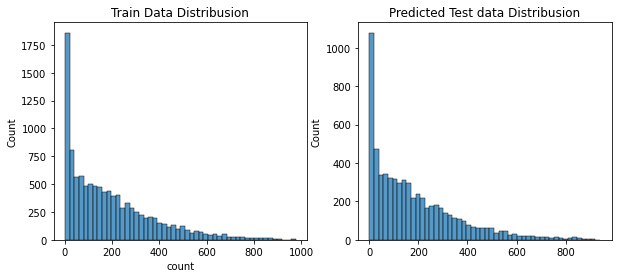

In [28]:
preds = grid_rf.best_estimator_.predict(X_test)

fig, axs = plt.subplots(ncols=2, figsize=(10,4))

sns.histplot(y, bins=50, ax=axs[0])
axs[0].set_title('Train Data Distribusion')
sns.histplot(np.exp(preds), bins=50, ax=axs[1])
axs[1].set_title('Predicted Test data Distribusion');

In [29]:
submission['count'] = np.exp(preds)
submission.to_csv('submission.csv', index=False)

# 성능 개선 4: 랜덤포레스트 최적화
- [소스 :  BIKE SHARING DEMAND [ RMSLE:: 0.3194]](https://www.kaggle.com/code/rajmehra03/bike-sharing-demand-rmsle-0-3194)
- 스코어 : 0.39446

In [30]:
no_of_test = [500]
param_grid = {'n_estimators':no_of_test, 'n_jobs':[-1], 'max_features':['auto', 'sqrt', 'log2']}
rf = GridSearchCV(estimator=RandomForestRegressor(), 
                 param_grid=param_grid,
                 scoring='neg_mean_squared_log_error',
                 cv=5)
rf.fit(X_train, log_y)

/home/tw/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/tw/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/tw/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomFore

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [500], 'n_jobs': [-1]},
             scoring='neg_mean_squared_log_error')

In [31]:
from sklearn.metrics import mean_squared_log_error
preds = rf.best_estimator_.predict(X_train)
print((np.sqrt(mean_squared_log_error(log_y, preds))))

0.04805869143251298


In [32]:
rf.best_params_

{'max_features': 'auto', 'n_estimators': 500, 'n_jobs': -1}

In [33]:
preds_rf = rf.best_estimator_.predict(X_test)
submission['count'] = np.exp(preds_rf)
submission.to_csv('submission.csv', index=False)

# 성능 개선 5 : XGBoost
- 스코어 : 0.38305

In [34]:
from xgboost import XGBRegressor

xgb = XGBRegressor()

param_grid = {'max_depth':[5, 7], 'min_child_weight':[1, 3], 'colsample_bytree':[0.5, 0.75]}
grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid)
grid_xgb.fit(X_train, log_y)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bytree': [0.5, 0.75], 'max_depth': [5, 7],
                         'min_child_weight': [1, 3]})

In [35]:
grid_xgb.best_params_

{'colsample_bytree': 0.75, 'max_depth': 5, 'min_child_weight': 1}

In [36]:
preds = grid_xgb.best_estimator_.predict(X_train)
print(f'xgb 회귀의 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

xgb 회귀의 RMSLE 값 : 0.2381


In [37]:
preds_xgb = grid_xgb.best_estimator_.predict(X_test)
submission['count'] = np.exp(preds_xgb)
submission.to_csv('submission.csv', index=False)

# 성능 개선 6 : 랜덤포레스트+XGBoost
- 스코어 : 0.37793

In [38]:
preds_ensemble = (preds_rf + preds_xgb)/2

In [39]:
submission['count'] = np.exp(preds_ensemble)
submission.to_csv('submission.csv', index=False)

# 성능 개선 7 : Tensorflow
- [소스:2 Creative Deep Learning Models//Bike Prediction](https://www.kaggle.com/code/homayoonkhadivi/2-creative-deep-learning-models-bike-prediction)
- Score: 0.4683

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [43]:
model = Sequential()
model.add(Dense(100, input_dim = X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [44]:
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,0,5
1,1,0,0,1,9.02,13.635,80,2011,1,5
2,1,0,0,1,9.02,13.635,80,2011,2,5
3,1,0,0,1,9.84,14.395,75,2011,3,5
4,1,0,0,1,9.84,14.395,75,2011,4,5


In [45]:
history = model.fit(X_train, log_y, epochs=100, batch_size=16,
                    validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100


/home/tw/.local/lib/python3.8/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


545/545 [==============================] - 1s 1ms/step - loss: 8279.7168 - val_loss: 37.7363
Epoch 2/100
545/545 [==============================] - 1s 1ms/step - loss: 232.3391 - val_loss: 16.2135
Epoch 3/100
545/545 [==============================] - 1s 1ms/step - loss: 75.3663 - val_loss: 15.8009
Epoch 4/100
545/545 [==============================] - 1s 1ms/step - loss: 33.2696 - val_loss: 10.0033
Epoch 5/100
545/545 [==============================] - 1s 1ms/step - loss: 21.4725 - val_loss: 8.1098
Epoch 6/100
545/545 [==============================] - 1s 1ms/step - loss: 15.2225 - val_loss: 6.1093
Epoch 7/100
545/545 [==============================] - 1s 1ms/step - loss: 10.7245 - val_loss: 6.3651
Epoch 8/100
545/545 [==============================] - 1s 1ms/step - loss: 8.9633 - val_loss: 7.4335
Epoch 9/100
545/545 [==============================] - 1s 1ms/step - loss: 7.2179 - val_loss: 8.3517
Epoch 10/100
545/545 [==============================] - 1s 1ms/step - loss: 6.5512 - val_

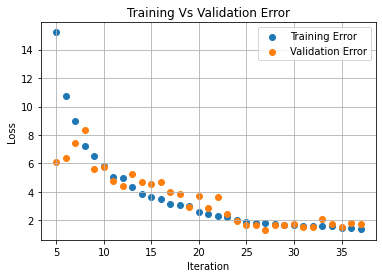

In [46]:
plt.scatter(x=history.epoch[5:],y=history.history['loss'][5:],label='Training Error')
plt.scatter(x=history.epoch[5:],y=history.history['val_loss'][5:],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

In [47]:
preds = model.predict(X_train)
print(f'tensorflow RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

341/341 [==============================] - 0s 603us/step
tensorflow RMSLE 값 : 1.5732


In [48]:
preds_dl = model.predict(X_test).reshape(6493)
preds_ensemble = (preds_rf + preds_xgb+preds_dl)/3

203/203 [==============================] - 0s 718us/step


In [49]:
preds_ensemble.shape

(6493,)

In [50]:
submission['count'] = np.exp(preds_ensemble)
submission.to_csv('submission.csv', index=False)